In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np


class RewardCalculator:
    def __init__(self, p):
        self.p = p

    def calculate_reward(self, X, lost_penalty=40, a=10, l=1, o=100, s=1):
        m_nr, t_nr = X.shape
        m = torch.tensor(np.ones(m_nr) * self.p, dtype=torch.float32, requires_grad=True)
        t = torch.tensor(np.ones(t_nr), dtype=torch.float32, requires_grad=True)
        mm = torch.zeros(t_nr, dtype=torch.float32)
        for tag in range(t_nr):
            mask = m[X[:, tag] == 1]  # mask for tag
            mm[tag] = torch.prod(mask)  # multiply the mask
        A = torch.matmul(X, (mm * t))

        L = [torch.where(X[:, torch.where(X[msg, :] == 1)[0][0]] == 1)[0][-1].item() - msg if A[msg] > 0 else lost_penalty for msg in range(m_nr)]
        L = torch.tensor(L, dtype=torch.float32)

        return a * torch.sum(A) - l * torch.sum(L)


class MatrixGenerator(nn.Module):
    def __init__(self, m_nr, t_nr):
        super(MatrixGenerator, self).__init__()
        self.m_nr = m_nr
        self.t_nr = t_nr
        self.fc = nn.Linear(m_nr * t_nr, m_nr * t_nr)
        self.sigmoid = nn.Sigmoid()

    def forward(self):
        x = self.fc(torch.randn(self.m_nr * self.t_nr))
        x = self.sigmoid(x)
        x = x.view(self.m_nr, self.t_nr)
        return x
    
class ComplexMatrixGenerator(nn.Module):
    def __init__(self, m_nr, t_nr):
        super(ComplexMatrixGenerator, self).__init__()
        self.m_nr = m_nr
        self.t_nr = t_nr

        self.model = nn.Sequential(
            nn.Linear(m_nr * t_nr, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Linear(128, m_nr * t_nr),
            nn.Sigmoid()
        )

    def forward(self):
        x = torch.ones(1, self.m_nr * self.t_nr)  # Create a 2D tensor with a batch size of 1
        x = self.model(x)
        x = x.view(self.m_nr, self.t_nr)
        return x

def train_model(generator, reward_calculator, optimizer, epochs=10000):
    for epoch in range(epochs):
        optimizer.zero_grad()
        X = generator()
        X = torch.bernoulli(X)
        reward = reward_calculator.calculate_reward(X)
        loss = -reward  # We want to maximize the reward
        loss.backward()
        optimizer.step()
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Reward: {-loss.item()}")

# Parameters
m_nr = 5  # number of messages (rows)
t_nr = 5  # number of tags (columns)
p = 0.5  # parameter for the reward function

# Instantiate the generator and the reward calculator
# generator = MatrixGenerator(m_nr, t_nr)
generator = ComplexMatrixGenerator(m_nr, t_nr)
reward_calculator = RewardCalculator(p)

# Define the optimizer
optimizer = optim.Adam(generator.parameters(), lr=0.01)

# Train the model
train_model(generator, reward_calculator, optimizer, epochs=1000000)

# Generate the optimized matrix
optimized_matrix = torch.bernoulli(generator()).detach().numpy()
print("Optimized Matrix:")
print(optimized_matrix)


Epoch 0, Reward: 10.75
Epoch 1000, Reward: 14.5
Epoch 2000, Reward: 11.75
Epoch 3000, Reward: 14.0
Epoch 4000, Reward: 11.0
Epoch 5000, Reward: 13.0
Epoch 6000, Reward: 13.3125
Epoch 7000, Reward: 7.5
Epoch 8000, Reward: 3.125
Epoch 9000, Reward: 13.25
Epoch 10000, Reward: 13.25
Epoch 11000, Reward: 12.25
Epoch 12000, Reward: 15.0
Epoch 13000, Reward: -26.5
Epoch 14000, Reward: 11.8125
Epoch 15000, Reward: 7.5
Epoch 16000, Reward: 9.75
Epoch 17000, Reward: 2.5
Epoch 18000, Reward: 11.0
Epoch 19000, Reward: 9.5
Epoch 20000, Reward: 16.5
Epoch 21000, Reward: 13.0
Epoch 22000, Reward: 19.0
Epoch 23000, Reward: 16.25
Epoch 24000, Reward: 14.5
Epoch 25000, Reward: 8.5
Epoch 26000, Reward: 16.25
Epoch 27000, Reward: 5.375
Epoch 28000, Reward: 16.0
Epoch 29000, Reward: -23.5
Epoch 30000, Reward: 6.0
Epoch 31000, Reward: 6.0625
Epoch 32000, Reward: 8.8125
Epoch 33000, Reward: 21.75
Epoch 34000, Reward: 7.8125
Epoch 35000, Reward: 18.5
Epoch 36000, Reward: 15.5
Epoch 37000, Reward: 6.5625
Epoch

Optimized Matrix:


<Axes: >

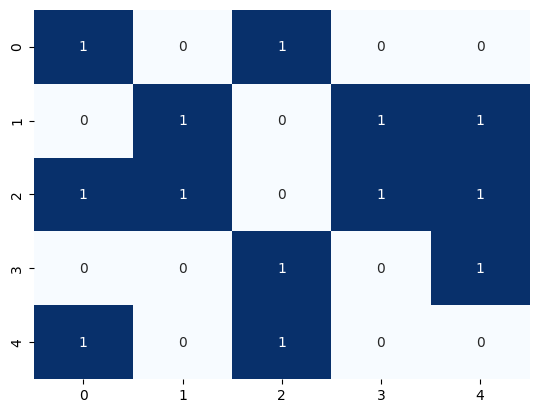

In [ ]:
optimized_matrix = torch.bernoulli(generator()).detach().numpy()
print("Optimized Matrix:")
import seaborn as sns
sns.heatmap(optimized_matrix, cmap="Blues", annot=True, cbar=False)